###### * Base Source: 
SAKT with Randomization & State Updates LB0.771 https://www.kaggle.com/leadbest/sakt-with-randomization-state-updates

1. Version 1: ++bundle_id-Embedding, ++tags-Embedding,  ++CustomTrainer
2. this is a repeat of version 8 of the notebook since at submission time I got this message:
"Cannot submit
Your Notebook cannot use internet access in this competition. Please disable internet in the Notebook editor and save a new version."
3. Hence, I am reusing the model trained at version 8 (rishi-sakt-featureembeddings-riidchallenge/SAKT_Rishi.pt). To get the original version 8 from this verson, remove the code: "model.load_state_dict..." and set the "num_train_epochs=13" in the first trainin loop. Second training loop still be "num_train_epochs=1" only.
4. The original version runs for 8 hrs.

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/rishi-sakt-featureembeddings-riidchallenge/SAKT_Rishi.pt
/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv
/kaggle/input/riiid-test-answer-prediction/example_test.csv
/kaggle/input/riiid-test-answer-prediction/questions.csv
/kaggle/input/riiid-test-answer-prediction/train.csv
/kaggle/input/riiid-test-answer-prediction/lectures.csv
/kaggle/input/riiid-test-answer-prediction/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/riiid-test-answer-prediction/riiideducation/__init__.py


In [2]:
import gc
import random
from   tqdm import tqdm
from   sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import psutil
import datatable as dt
from collections import namedtuple  

import os
import seaborn as sns
from   sklearn.utils import shuffle
import datetime
import time
from   sklearn.metrics import accuracy_score, precision_recall_fscore_support, matthews_corrcoef, roc_auc_score

import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils
from   torch.autograd import Variable
from   torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from   transformers import TrainingArguments
from   transformers import AdamW, BertConfig
from   transformers import get_linear_schedule_with_warmup

In [3]:
MAX_SEQ = 256

## Load train df and join the tags column from the questions df

In [4]:
%%time
dtype = {'timestamp'         :'int64', 
         'user_id'           :'int32' ,
         'content_id'        :'int16',
         'content_type_id'   :'int8',
         'answered_correctly':'int8'}

train_df = pd.read_csv ('../input/riiid-test-answer-prediction/train.csv', usecols=[1, 2, 3, 4, 7], dtype=dtype)
# train_df = train_df.sample (frac=0.0001)  # TODO: comment this
train_df.head ()

CPU times: user 1min 9s, sys: 4.94 s, total: 1min 14s
Wall time: 1min 57s


,timestamp,user_id,content_id,content_type_id,answered_correctly
0,0,115,5692,0,1
1,56943,115,5716,0,1
2,118363,115,128,0,1
3,131167,115,7860,0,1
4,137965,115,7922,0,1


In [5]:
dtype = {
    'question_id' :'int16',
    'bundle_id'   :'int16', 
    'tags'        :'str',
}
questions_df         = pd.read_csv ('../input/riiid-test-answer-prediction/questions.csv', usecols=[0, 1, 4], dtype=dtype)
# convert tag from string and pad the tags with 0 and make it as fixed length (=5) array
questions_df['tags'] = questions_df['tags'].map (lambda s: [int(v) for v in s.split()], 'ignore')
questions_df['tags'] = questions_df['tags'].fillna (0)
questions_df['tags'] = questions_df['tags'].map (lambda s: [0]*5 if s==0 else s*(5//len(s))+s[:5%len(s)] if len(s)<5 else s[:5] )
questions_df.head ()

,question_id,bundle_id,tags
0,0,0,"[51, 131, 162, 38, 51]"
1,1,1,"[131, 36, 81, 131, 36]"
2,2,2,"[131, 101, 162, 92, 131]"
3,3,3,"[131, 149, 162, 29, 131]"
4,4,4,"[131, 5, 162, 38, 131]"


In [6]:
train_df = train_df[train_df.content_type_id == False]
#arrange by timestamp
train_df = train_df.sort_values (['timestamp'], ascending=True).reset_index (drop = True)

## Preprocess

In [7]:
known_bundle_ids = set (questions_df["bundle_id"].unique())
print("number bundles =", len (known_bundle_ids))
n_bundles = max (known_bundle_ids) + 1
n_bundles

number bundles = 9765


13523

In [8]:
skills  = train_df["content_id"].unique ()
# n_skill = max (skills) + 1
# max (skills), len(skills)

In [9]:
known_qtn_ids = set (questions_df["question_id"].unique())
print ("number questions =", len (known_qtn_ids))
n_skill = max (known_qtn_ids) + 1
n_skill

number questions = 13523


13523

In [10]:
known_tags = questions_df["tags"].apply (pd.Series).unstack ().reset_index ().dropna ()
known_tags = set (known_tags[0].astype ('int16').unique ())
n_tags     = max (known_tags) + 1
n_tags, len (known_tags)

(188, 188)

In [11]:
# train_df = train_df.merge (questions_df, left_on='content_id', right_on='question_id', how='left').drop (columns=['question_id'])
gc.collect ()
train_df.head ()

,timestamp,user_id,content_id,content_type_id,answered_correctly
0,0,115,5692,0,1
1,0,1805962620,5547,0,0
2,0,2015251289,4024,0,1
3,0,867941388,6659,0,1
4,0,867946278,3977,0,1


In [12]:
# To save from going out of memory, split the df into 2, then create the groups below and join them back
train_df_1 = train_df[:train_df.shape[0]//2]
train_df_2 = train_df[train_df.shape[0]//2:]
del train_df; gc.collect ()                  # TODO - uncomment this

group = train_df_1[['user_id', 'content_id', 'answered_correctly']].groupby('user_id').apply (lambda r: (
            r['content_id'].values,
            r['answered_correctly'].values,
))
del train_df_1
gc.collect ()
group

user_id
115           ([5692, 5716, 128, 7860, 7922, 156, 51, 50, 78...
124           ([7900, 7876, 175, 1278, 2065, 2063, 2064, 336...
2746          ([5273, 758, 5976, 236, 404, 382, 405, 873, 53...
5382          ([5000, 3944, 217, 5844, 5965, 4990, 5235, 605...
8623          ([3915, 4750, 6456, 3968, 6104, 5738, 6435, 54...
                                    ...                        
2147470770    ([7900, 7876, 175, 1278, 2064, 2063, 2065, 336...
2147470777    ([7900, 7876, 175, 1278, 2065, 2063, 2064, 336...
2147481750    ([4137, 1270, 9261, 8201, 367, 378, 214, 6071,...
2147482216    ([3748, 4765, 5474, 9261, 4665, 5987, 6666, 56...
2147482888    ([6147, 4792, 5738, 6102, 4748, 7956, 6435, 92...
Length: 393656, dtype: object

In [13]:
group_2 = train_df_2[['user_id', 'content_id', 'answered_correctly']].groupby('user_id').apply (lambda r: (
            r['content_id'].values,
            r['answered_correctly'].values,
))
del train_df_2
gc.collect ()
group_2

user_id
12741         ([10071, 10072, 10070, 10073, 10950, 10948, 10...
13134         ([8736, 6156, 1030, 11875, 902, 317, 1224, 120...
24418         ([4821, 5177, 6328, 9187, 649, 207, 1181, 317,...
40828         ([4782, 4975, 9536, 3859, 5618, 6265, 8910, 41...
44331         ([153, 10767, 10770, 10769, 10768, 6917, 6916,...
                                    ...                        
2147382115    ([6058, 9171, 5544, 4821, 6121, 8561, 5631, 59...
2147413636    ([1911, 1912, 1910, 2424, 2423, 2422, 567, 515...
2147419988    ([7946, 10577, 185, 7908, 130, 10405, 10485, 8...
2147470770    ([1383, 951, 1296, 1217, 749, 582, 438, 972, 8...
2147470777    ([141, 127, 7881, 10646, 7913, 38, 25, 10651, ...
Length: 123833, dtype: object

In [14]:
# merge the groups
group_2_set = set (group_2.index)
for k in group.index:
    if k in group_2_set:
        
        group[k] = (np.append (group[k][0],  group_2[k][0]), np.append (group[k][1],  group_2[k][1]) ) #, np.append (group[k][2],  group_2[k][2]), np.vstack ((group[k][3], group_2[k][3])) )
        group_2.pop (k)
gc.collect ()
group = group.append (group_2)
del group_2; gc.collect ()
print ('len (group) =', len (group))
group

len (group) = 393656


user_id
115           ([5692, 5716, 128, 7860, 7922, 156, 51, 50, 78...
124           ([7900, 7876, 175, 1278, 2065, 2063, 2064, 336...
2746          ([5273, 758, 5976, 236, 404, 382, 405, 873, 53...
5382          ([5000, 3944, 217, 5844, 5965, 4990, 5235, 605...
8623          ([3915, 4750, 6456, 3968, 6104, 5738, 6435, 54...
                                    ...                        
2147470770    ([7900, 7876, 175, 1278, 2064, 2063, 2065, 336...
2147470777    ([7900, 7876, 175, 1278, 2065, 2063, 2064, 336...
2147481750    ([4137, 1270, 9261, 8201, 367, 378, 214, 6071,...
2147482216    ([3748, 4765, 5474, 9261, 4665, 5987, 6666, 56...
2147482888    ([6147, 4792, 5738, 6102, 4748, 7956, 6435, 92...
Length: 393656, dtype: object

In [15]:
random.seed (1)

In [16]:
class SAKTDataset (Dataset):
    
    def __init__(self, group, n_skill, max_seq=MAX_SEQ):
        
        super (SAKTDataset, self).__init__()
        self.max_seq   = max_seq
        self.n_skill   = n_skill
        self.n_bundles = n_bundles
        self.n_tags    = n_tags
        self.samples   = group
        
        # self.user_ids = [x for x in group.index]
        self.user_ids  = []
        for user_id in group.index:
            
            # q, qa, b, t = group[user_id]
            q, qa = group[user_id]
            if len(q) < 2: #  10
                continue
            self.user_ids.append (user_id)
            
            # Memory reduction
            # if len(q)>self.max_seq:
            #     group[user_id] = (q[-self.max_seq:],qa[-self.max_seq:])
        return

    def __len__(self):
        return len(self.user_ids)

    def __getitem__(self, index):
        
        user_id  = self.user_ids[index]
        # q_, qa_, b_, t_ = self.samples[user_id]
        q_, qa_  = self.samples[user_id]
        q_b_t_df = pd.DataFrame.from_dict ({'question_id': q_})
        q_b_t_df = q_b_t_df.merge (questions_df, on='question_id', how='left')
        b_       = q_b_t_df.bundle_id.values
        t_       = np.vstack (q_b_t_df.tags.values)
        del q_b_t_df
        seq_len  = len (q_)
        
        q  = np.zeros (self.max_seq, dtype=int)
        qa = np.zeros (self.max_seq, dtype=int)
        b  = np.zeros (self.max_seq, dtype=int)
        t  = np.array ([[0]*5]*self.max_seq, dtype=int)  # a question can have upto say 5 tags
        
        if seq_len >= self.max_seq:
            if random.random ()>0.1:
                
                start = random.randint (0,(seq_len-self.max_seq))
                end   = start + self.max_seq
                q[:]  = q_[start:end]
                qa[:] = qa_[start:end]
                b[:]  = b_[start:end]
                t[:]  = t_[start:end]
            else:
                
                q[:]  = q_[-self.max_seq:]
                qa[:] = qa_[-self.max_seq:]
                b[:]  = b_[-self.max_seq:]
                t[:]  = t_[-self.max_seq:]
        else:
            if random.random ()>0.1:
                
                start = 0
                end = random.randint (2,seq_len)
                seq_len = end - start
                q[-seq_len:]  = q_[0:seq_len]
                qa[-seq_len:] = qa_[0:seq_len]
                b[-seq_len:]  = b_[0:seq_len]
                t[-seq_len:]  = t_[0:seq_len]
            else:
                
                q[-seq_len:]  = q_
                qa[-seq_len:] = qa_
                b[-seq_len:]  = b_
                t[-seq_len:]  = t_
        target_id = q[1:]
        label = qa[1:]

        x = np.zeros (self.max_seq-1, dtype=int)
        x = q[:-1].copy ()
        x += (qa[:-1] == 1) * self.n_skill
        
        bundle_x = b[:-1].copy ()
        tags_x   = t[:-1].copy ()
        b_target = b[1:]
        t_target = t[1:]
        
        return x, target_id, label, bundle_x, tags_x, b_target, t_target

## Define model

In [17]:
class FFN (nn.Module):
    
    def __init__(self, state_size=200):
        super (FFN, self).__init__()
        self.state_size = state_size

        self.lr1 = nn.Linear (state_size, state_size)
        self.relu = nn.ReLU ()
        self.lr2 = nn.Linear (state_size, state_size)
        self.dropout = nn.Dropout (0.2)
    
    def forward (self, x):
        x = self.lr1 (x)
        x = self.relu (x)
        x = self.lr2 (x)
        return self.dropout (x)

def future_mask (seq_length):
    future_mask = np.triu (np.ones ((seq_length, seq_length)), k=1).astype ('bool')
    return torch.from_numpy (future_mask)


class SAKTModel (nn.Module):
    
    def __init__(self, n_skill, max_seq=MAX_SEQ, embed_dim=128): #  100->MAX_SEQ
        super(SAKTModel, self).__init__()
        self.n_skill   = n_skill
        self.embed_dim = embed_dim

        self.embedding        = nn.Embedding (2*n_skill+1, embed_dim)
        self.pos_embedding    = nn.Embedding (max_seq-1,   embed_dim)
        self.e_embedding      = nn.Embedding (n_skill+1,   embed_dim)
        self.bundle_embedding = nn.Embedding (n_bundles,   embed_dim)
        self.tag_embedding    = nn.Embedding (n_tags,      embed_dim)

        self.multi_att    = nn.MultiheadAttention (embed_dim=embed_dim, num_heads=8, dropout=0.2)

        self.dropout      = nn.Dropout (0.2)
        self.layer_normal = nn.LayerNorm (embed_dim) 
        self.ffn          = FFN (embed_dim)
        self.outDense     = nn.Linear (embed_dim, 2)
        self.outActivtn   = nn.LogSoftmax (dim=1)
        self.NLLLoss      = nn.NLLLoss ()             # criterion
        return
    
    def getTagsEmb (self, tags):
        """
        list_of_tagList 3D np.array of size (1, seqLen, 5) 
        """
        
        t_emb = self.tag_embedding (tags)
        t_emb = torch.mean (t_emb, dim=-2)
        return t_emb
        
    def forward (self, x, question_ids, bundle_x, tags_x, b_target, t_target, labels=None):
        """
        when you call `model (x ,y, z, ...)` then thid method is invoked
        """
        
        device   = x.device                                            #;print ('x.shape        =', x.shape)
        x        = self.embedding (x)                                  #;print ('x.shape        =', x.shape)
        pos_id   = torch.arange (x.size (1)).unsqueeze (0).to (device) #;print ('pos_id.shape   =', pos_id.shape)
        pos_x    = self.pos_embedding (pos_id)                         #;print ('pos_x.shape    =', pos_x.shape)
        bundle_x = self.bundle_embedding (bundle_x)                    #;print ('bundle_x.shape =', bundle_x.shape)
        b_target = self.bundle_embedding (b_target)                    #;print ('b_target.shape =', b_target.shape)
        tags_x   = self.getTagsEmb (tags_x)                            #;print ('tags_x.shape   =', tags_x.shape)
        t_target = self.getTagsEmb (t_target)                          #;print ('t_target.shape =', t_target.shape)
        
        # x    = x + pos_x
        x      = x + pos_x + bundle_x + tags_x                         #;print ('x.shape        =', x.shape) 
        # e    = self.e_embedding (question_ids)
        e      = self.e_embedding (question_ids) + b_target + t_target #;print ('e.shape        =', e.shape)
        
        x = x.permute (1, 0, 2) ;"""x: [bs, s_len, embed] => [s_len, bs, embed]"""   #;print ('x.shape        =', x.shape)
        e = e.permute (1, 0, 2)                                        #;print ('e.shape        =', e.shape)
        att_mask   = future_mask (x.size (0)).to (device)              #;print ('att_mask.shape = ', att_mask.shape) 
        att_output, att_weight = self.multi_att (e, x, x, attn_mask=att_mask)   #;print ('att_output.shape = ', att_output.shape) 
        att_output = self.layer_normal (att_output + e)                #;print ('att_output.shape = ', att_output.shape) 
        att_output = att_output.permute (1, 0, 2) #;"""att_output: [s_len, bs, embed] => [bs, s_len, embed]""" ;print ('att_output.shape = ', att_output.shape) 

        x          = self.ffn (att_output)                             #;print ('x.shape = ', x.shape) 
        x          = self.layer_normal (x + att_output)                #;print ('x.shape = ', x.shape) 
        out_logits = self.outDense (x)                                 #;print ('out_logits.shape = ', out_logits.shape)        
        
        if labels is None:
            
            # target question id is the last in the sequence of target question ids, hence return the last col
            out_logits = out_logits[:, -1]
            # return a named tuple
            Logits     = namedtuple ('Logits',['logits'])
            out_logits = Logits (out_logits)
            return out_logits
        
        out_logits = out_logits.view (out_logits.shape[0] * out_logits.shape[1], -1)           #;print ('out_logits.shape = ', out_logits.shape)
        log_ps     = self.outActivtn (out_logits)                                              # ;print('labels.size=', labels.size(), 'log_ps.size=', log_ps.size())
        labels     = torch.squeeze (labels.view (labels.shape[0] * labels.shape[1], -1), -1)   # ;print ('labels.shape = ', labels.shape)
        batchLoss  = self.NLLLoss (log_ps, labels)
        
        # return a named tuple
        Loss_Logits = namedtuple ('Loss_Logits',['loss','logits'])
        loss_logits = Loss_Logits (batchLoss, out_logits)
        return loss_logits

# Create Train and Eval Datasets and train

In [18]:
frac  = 0.05
temp  = list (group.index)
temp  = shuffle (temp)
frac  = int (len (temp) * frac)
temp2 = temp[:frac]
temp  = temp[frac:]
train_group = group[temp]
eval_group  = group[temp2]
del group
gc.collect ()
print ('len (train_group) =', len (train_group))
print ('len (eval_group) =',  len (eval_group))
train_group

len (train_group) = 373974
len (eval_group) = 19682


user_id
2058553426    ([7900, 7876, 175, 1278, 2064, 2065, 2063, 336...
1658799651    ([7900, 7876, 175, 1278, 2065, 2064, 2063, 336...
564422495     ([7900, 7876, 175, 1278, 2065, 2063, 2064, 336...
1744078086    ([3560, 8275, 98, 6374, 5070, 5651, 5338, 5673...
1980281378    ([7900, 7876, 175, 1278, 2064, 2063, 2065, 336...
                                    ...                        
1726635395    ([4303, 1328, 367, 5613, 3577, 4536, 8503, 448...
399439114     ([3817, 5564, 1294, 4058, 5182, 98, 4934, 5624...
203070452     ([7900, 7876, 175, 1278, 2063, 2065, 2064, 336...
758084219     ([7900, 7876, 175, 1278, 2064, 2065, 2063, 336...
746969510     ([6258, 4841, 9557, 8358, 8388, 4511, 3939, 49...
Length: 373974, dtype: object

In [19]:
train_dataset = SAKTDataset (train_group, n_skill)
eval_dataset  = SAKTDataset (eval_group,  n_skill)
print (train_dataset[1][0].shape, train_dataset[1][1].shape, train_dataset[1][2].shape, train_dataset[1][3].shape, train_dataset[1][4].shape, train_dataset[1][5].shape, train_dataset[1][6].shape)

(255,) (255,) (255,) (255,) (255, 5) (255,) (255, 5)


In [20]:
# Utilities for my custom trainer

def format_time (elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str (datetime.timedelta (seconds=elapsed_rounded))

def compute_metrics (labels, pred_logits):
    
    preds   = pred_logits.argmax (-1)             #;print ('labels.shape=', labels.shape, 'preds.shape=', preds.shape, 'pred_logits.shape=', pred_logits.shape)
    precision, recall, f1, _ = precision_recall_fscore_support (labels, preds, average='macro')
    acc     = accuracy_score (labels, preds)
    mcc     = matthews_corrcoef (labels, preds)   # matthews correlation coefficient
    softmax = nn.Softmax (dim=1)
    pred_pr = softmax (torch.tensor (pred_logits))
    auc     = roc_auc_score (labels, pred_pr[:, 1])
    metrics = {
        'mcc'      : mcc,
        'accuracy' : acc,
        'f1'       : f1,
        'precision': precision,
        'recall'   : recall,
        'auc'      : auc
    }
    return metrics

In [21]:
class MyTrainer:
    
    def __init__(self, model, args, train_dataset, eval_dataset, compute_metrics=compute_metrics):
        
        self.model           = model
        self.args            = args
        self.train_dataset   = train_dataset
        self.eval_dataset    = eval_dataset
        self.compute_metrics = compute_metrics
        self.isTrained       = False
        self.device          = self.get_device_type ()
        
        # Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
        # I believe the 'W' stands for 'Weight Decay fix"
        self.optimizer = AdamW (model.parameters (),
                           lr  = args.learning_rate,
                           eps = args.adam_epsilon # args.adam_epsilon  - default is 1e-8 is “a very small number to prevent any division by zero"
        )

        # Number of training epochs. The BERT authors recommend between 2 and 4. 
        # We chose to run for 4, but we'll see later that this may be over-fitting the
        # training data.
        self.epochs = self.args.num_train_epochs
        self.train_dataloader, self.validation_dataloader, self.lr_scheduler, self.num_training_steps = self.get_dataLoaders ()        
        return
    
    def get_device_type (self):
        
        # If there's a GPU available...
        if torch.cuda.is_available ():    

            # Tell PyTorch to use the GPU.    
            device = torch.device ("cuda")
            print('There are %d GPU(s) available.' % torch.cuda.device_count ())
            print('We will use the GPU:', torch.cuda.get_device_name (0))
        # If not...
        else:
            print('No GPU available, using the CPU instead.')
            device = torch.device ("cpu")
        return device
    
    def get_dataLoaders (self):        
        
        # Create the DataLoaders for our training and validation sets.
        if isinstance (self.train_dataset, torch.utils.data.IterableDataset):
            train_sampler = None
        else:
            train_sampler = SequentialSampler (self.train_dataset)       # Better use RandomSampler
        train_dataloader  = DataLoader (
                    self.train_dataset,                                  # The training samples.
                    sampler     = train_sampler,                           
                    batch_size  = self.args.per_device_train_batch_size,
                    num_workers = 8    # TODO: uncomment this
        )
        validation_dataloader = None
        if self.eval_dataset:
            
            # For validation the order doesn't matter, so we'll just read them sequentially.
            validation_dataloader = DataLoader (
                        self.eval_dataset,             # The validation/dev samples.
                        sampler     = SequentialSampler (self.eval_dataset),
                        batch_size  = self.args.per_device_eval_batch_size,
                        num_workers = 8    # TODO: uncomment this
            )
        
        # Total number of training steps is [number of batches] x [number of epochs]. 
        # (Note that this is not the same as the number of training samples).
        num_training_steps = len (train_dataloader) * self.epochs

        # Create the learning rate scheduler.
        lr_scheduler = get_linear_schedule_with_warmup (self.optimizer, 
                                                        num_warmup_steps   = self.args.warmup_steps, # Default value in run_glue.py
                                                        num_training_steps = num_training_steps)
        return train_dataloader, validation_dataloader, lr_scheduler, num_training_steps
    
    
    def test_iterate_dataloader ():
        
        for step, batch in enumerate (self.train_dataloader):
            print (step)
            print (batch)
            break
        return
    
    
    def train (self):
        
        # This training code is based on the `run_glue.py` script here:
        # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
        
        # Set the seed value all over the place to make this reproducible.
        seed_val = 42
        random.seed (seed_val)
        np.random.seed (seed_val)
        torch.manual_seed (seed_val)
        torch.cuda.manual_seed_all (seed_val)

        # We'll store a number of quantities such as training and validation loss, 
        # validation accuracy, and timings.
        training_stats = []
        # Measure the total training time for the whole run.
        total_t0 = time.time ()
        # inint min_val_loss to a large val, if after each epoch eval-loss < min_val_loss, then save the model
        min_val_loss   = 9999
        min_train_loss = 9999
        step = 0
        
        # For each epoch...
        for epoch_i in range (0, self.epochs):

            # ========================================
            #               Training
            # ========================================

            # Perform one full pass over the training set.

            print("")
            print('======== Epoch {:} / {:} ========'.format (epoch_i + 1, self.epochs))
            print('Training...')

            # Measure how long the training epoch takes.
            t0 = time.time ()

            # Reset the total loss for this epoch.
            total_train_loss = 0

            # Put the model into training mode. Don't be mislead--the call to 
            # `train` just changes the *mode*, it doesn't *perform* the training.
            # `dropout` and `batchnorm` layers behave differently during training
            # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
            self.model.train ()

            # For each batch of training data...
            for stp, batch in enumerate (self.train_dataloader):

                step += 1
                # Progress update every 40 batches.
                # print ('batch =', batch)
                if step % 50 == 0 and not step == 0:
                    
                    # Calculate elapsed time in minutes.
                    elapsed = format_time (time.time() - t0)
                    # Report progress.
                    print ('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len (self.train_dataloader), elapsed))
                if (self.args.max_steps > 0 and self.args.max_steps < step) or  \
                   (self.args.eval_steps> 0 and step % self.args.eval_steps==0 and step>0):
                    
                    avg_train_loss = total_train_loss / step
                    training_time = format_time (time.time () - t0)
                    if self.validation_dataloader:
                        
                        print ("Running Validation...")
                        avg_val_loss, avg_val_f1, avg_val_mcc, avg_val_auc, avg_val_precision, avg_val_recall, avg_val_accuracy, validation_time = self.evaluate ()
                        training_stats.append ({
                                'epoch'         : epoch_i + 1,
                                'training_loss' : avg_train_loss,
                                'eval_loss'     : avg_val_loss,
                                'eval_f1'       : avg_val_f1,
                                'eval_mcc'      : avg_val_mcc, 
                                'eval_precision': avg_val_precision,
                                'eval_recall'   : avg_val_recall,
                                'eval_auc'      : avg_val_auc, 
                                'eval_accuracy' : avg_val_accuracy,
                                'training_time' : training_time,
                                'eval_time'     : validation_time                   
                        })
                        # save this model if the eval loss decreases from the minimum so far
                        if avg_val_loss < min_val_loss: 

                            min_val_loss = avg_val_loss
                            torch.save (model.state_dict (), "SAKT_Rishi.pt")     # TODO: uncomment this                    
                self.model.zero_grad ()        

                # Perform a forward pass (evaluate the model on this training batch).
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # It returns different numbers of parameters depending on what arguments
                # arge given and what flags are set. For our useage here, it returns
                # the loss (because we provided labels) and the "logits"--the model
                # outputs prior to activation.
                # loss, logits = self.model (b_inputs, .., labels=b_labels)
                # print ('batch: \n', batch)
                x         = batch[0].to (device).long ()
                target_id = batch[1].to (device).long ()
                labels    = batch[2].to (device).long ()
                bundle_x  = batch[3].to (device).long ()
                tags_x    = batch[4].to (device).long ()
                b_target  = batch[5].to (device).long ()
                t_target  = batch[6].to (device).long ()
                output    = self.model (x, target_id, bundle_x, tags_x, b_target, t_target, labels)
                loss      = output.loss
                logits    = output.logits
                
                # Accumulate the training loss over all of the batches so that we can
                # calculate the average loss at the end. `loss` is a Tensor containing a
                # single value; the `.item()` function just returns the Python value 
                # from the tensor.
                total_train_loss += loss.item ()
                # Perform a backward pass to calculate the gradients.
                loss.backward ()

                # Clip the norm of the gradients to 1.0.
                # This is to help prevent the "exploding gradients" problem.
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                # Update parameters and take a step using the computed gradient.
                # The optimizer dictates the "update rule"--how the parameters are
                # modified based on their gradients, the learning rate, etc.
                self.optimizer.step ()
                # Update the learning rate.
                self.lr_scheduler.step ()
            # At the end of each epoch measure stats and eval:
            # Calculate the average loss over all of the batches.
            avg_train_loss = total_train_loss / len (self.train_dataloader)
            # Measure how long this epoch took.
            training_time = format_time (time.time () - t0)            
            print ("  Average training loss: {0:.2f}".format (avg_train_loss))
            print ("  Training epcoh took: {:}".format (training_time))
            
            if self.validation_dataloader:
                
                print ("\n  Running Validation...")
                avg_val_loss, avg_val_f1, avg_val_mcc, avg_val_auc, avg_val_precision, avg_val_recall, avg_val_accuracy, validation_time = self.evaluate ()
                # Record all statistics from this epoch.
                training_stats.append ({
                        'epoch'         : epoch_i + 1,
                        'training_loss' : avg_train_loss,
                        'eval_loss'     : avg_val_loss,
                        'eval_f1'       : avg_val_f1,
                        'eval_mcc'      : avg_val_mcc, 
                        'eval_precision': avg_val_precision,
                        'eval_recall'   : avg_val_recall,
                        'eval_auc'      : avg_val_auc, 
                        'eval_accuracy' : avg_val_accuracy,
                        'training_time' : training_time,
                        'eval_time'     : validation_time                   
                })
                # save this epoch's model if the eval loss decreases from the minimum so far
                if avg_val_loss < min_val_loss:
                    
                    min_val_loss = avg_val_loss
                    torch.save (model.state_dict (), "SAKT_Rishi.pt")     # TODO: uncomment this
            else:
                
                training_stats.append ({
                    'epoch'         : epoch_i + 1,
                    'training_loss' : avg_train_loss,
                    'training_time' : training_time,
                })
                if avg_train_loss < min_train_loss: 
                    
                    min_train_loss = avg_train_loss
                    torch.save (model.state_dict (), "SAKT_Rishi.pt")     # TODO: uncomment this
        print ("")
        print ("Training complete!")
        print ("Total training took {:} (h:mm:ss)".format (format_time (time.time ()-total_t0)))
        self.isTrained = True
        self.plot_train_stats (training_stats)
        return training_stats
    
    def evaluate (self):
        
        t0 = time.time ()
        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        self.model.eval ()

        # Tracking variables 
        total_eval_mcc       = 0
        total_eval_f1        = 0
        total_eval_precision = 0
        total_eval_recall    = 0
        total_eval_auc       = 0
        total_eval_accuracy  = 0
        total_eval_loss      = 0
        nb_eval_steps        = 0

        # Evaluate data for one epoch
        for batch in self.validation_dataloader:
            with torch.no_grad ():
                
                # Forward pass, calculate logit predictions.
                x         = batch[0].to (device).long ()
                target_id = batch[1].to (device).long ()
                labels    = batch[2].to (device).long ()
                bundle_x  = batch[3].to (device).long ()
                tags_x    = batch[4].to (device).long ()
                b_target  = batch[5].to (device).long ()
                t_target  = batch[6].to (device).long ()
                output    = self.model (x, target_id, bundle_x, tags_x, b_target, t_target, labels)
                loss      = output.loss
                logits    = output.logits

            # Accumulate the validation loss.
            total_eval_loss += loss.item ()
            # Move logits and labels to CPU
            logits    = logits.detach ().cpu ().numpy ()
            label_ids = labels.to ('cpu').numpy ()
            label_ids = np.squeeze (label_ids.reshape ((label_ids.shape[0] * label_ids.shape[1], -1)), -1)

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            metrics = self.compute_metrics (label_ids, logits)
            total_eval_mcc       += metrics['mcc']
            total_eval_f1        += metrics['f1']
            total_eval_precision += metrics['precision']
            total_eval_recall    += metrics['recall']
            total_eval_auc       += metrics['auc']
            total_eval_accuracy  += metrics['accuracy']

        # Report the final accuracy for this validation run.
        avg_val_f1 = total_eval_f1 / len (self.validation_dataloader)
        print ("  F1: {0:.3f}".format (avg_val_f1))
        avg_val_mcc = total_eval_mcc / len (self.validation_dataloader)
        print ("  MCC: {0:.3f}".format (avg_val_mcc))
        avg_val_precision = total_eval_precision / len (self.validation_dataloader)
        print ("  Precision: {0:.3f}".format (avg_val_precision))
        avg_val_recall = total_eval_recall / len (self.validation_dataloader)
        print ("  Recall: {0:.3f}".format (avg_val_recall))
        avg_val_auc = total_eval_auc / len (self.validation_dataloader)
        print ("  AUC: {0:.3f}".format (avg_val_auc))
        avg_val_accuracy = total_eval_accuracy / len (self.validation_dataloader)
        print ("  Accuracy: {0:.3f}".format (avg_val_accuracy))
        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len (self.validation_dataloader)
        # Measure how long the validation run took.
        validation_time = format_time (time.time () - t0)
        print ("  Validation Loss: {0:.2f}".format (avg_val_loss))
        print ("  Validation took: {:}".format (validation_time))            
        return avg_val_loss, avg_val_f1, avg_val_mcc, avg_val_auc, avg_val_precision, avg_val_recall, avg_val_accuracy, validation_time
    
    def plot_train_stats (self, training_stats):
        """
        Draw Classification Report curve
        """
        
        mccs   = accuracies = f1_scores = precisions = recalls = auc = losses = epochs = -1
        epochs = training_stats[-1]['epoch']
        if 'eval_mcc' in training_stats[0]:
            mccs       = [e['eval_mcc'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=mccs,       label='val_mcc')
        if 'eval_accuracy' in training_stats[0]:
            accuracies = [e['eval_accuracy'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=accuracies, label='val_accuracy')
        if 'eval_f1' in training_stats[0]:
            f1_scores  = [e['eval_f1'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=f1_scores,  label='val_f1') 
        if 'eval_precision' in training_stats[0]:
            precisions = [e['eval_precision'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=precisions, label='val_precision')
        if 'eval_recall' in training_stats[0]:
            recalls    = [e['eval_recall'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=recalls,    label='val_recall')
        if 'eval_auc' in training_stats[0]:
            auc        = [e['eval_auc'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=mccs,       label='val_auc')
        if 'eval_loss' in training_stats[0]:
            losses     = [e['eval_loss'] for e in training_stats]
        if 'training_loss'  in training_stats[0]:
            tr_losses  = [e['training_loss'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=tr_losses,  label='tr_losses')
            
        plt.show ()
        print ('mccs       :', mccs)
        print ('accuracies :', accuracies)
        print ('precisions :', precisions)
        print ('recalls    :', recalls)
        print ('f1_scores  :', f1_scores)
        print ('auc        :', auc)
        print ('losses     :', losses)
        print ('tr_losses  :', tr_losses)
        return
    
    
    def getTrainedModel (self):
        
        if self.isTrained:
            return self.model
        return None
    
    
    def predict (self, prediction_dataset, isRemoveLabels=True):
        """
        return: pred_logits, true_labels, metrics (if true 'labels' are input in the prediction_dataset)
        """     
        
        prediction_sampler    = SequentialSampler (prediction_dataset)
        prediction_dataloader = DataLoader (prediction_dataset, sampler=prediction_sampler, batch_size=self.args.per_device_eval_batch_size)
        print ('Predicting labels for {:,} test sentences...'.format (len (prediction_dataset)))
        
        # Put model in evaluation mode
        self.model.eval ()

        # Tracking variables 
        predictions = []
        # true_labels = []
        
        # Predict 
        for batch in prediction_dataloader:
            
            # Add batch to GPU
            batch = {t:batch[t].to (self.device) for t in batch}

            # Unpack the inputs from our dataloader
            # b_input_ids, b_input_mask, b_segment_ids = batch

            # Telling the model not to compute or store gradients, saving memory and 
            # speeding up prediction
            with torch.no_grad ():
                # Forward pass, calculate logit predictions
                if isRemoveLabels:
                    batch.pop ('labels')
                for k in batch:
                    batch[k] = batch[k].to (self.device)
                outputs = model (**batch)
            logits = outputs[0]

            # Move logits and labels to CPU
            logits = logits.detach ().cpu ().numpy ()
            # label_ids = b_labels.to ('cpu').numpy ()

            # Store predictions and true labels
            predictions.append (logits)
            # true_labels.append (label_ids)
            print ('Done predictions for ', len(predictions), '/', len(prediction_dataloader), 'batches')
        print ('Done prediction')
        
        # Combine the results across all batches to get the predicted logits
        pred_logits = np.concatenate (predictions, axis=0)
        # For each sample, pick the label (0,1,2) with the highest score.
        # pred_labels = np.argmax (pred_logits, axis=1).flatten()
        # returns the predicted logits
        return pred_logits, None, None

In [22]:
device = torch.device ("cuda" if torch.cuda.is_available() else "cpu")

model = SAKTModel (n_skill, embed_dim=128)
try:
    model.load_state_dict (torch.load ("../input/rishi-sakt-featureembeddings-riidchallenge/SAKT_Rishi.pt"))
except:
    model.load_state_dict (torch.load ("../input/rishi-sakt-featureembeddings-riidchallenge/SAKT_Rishi.pt", map_location='cpu'))

model.to (device)

SAKTModel(
  (embedding): Embedding(27047, 128)
  (pos_embedding): Embedding(255, 128)
  (e_embedding): Embedding(13524, 128)
  (bundle_embedding): Embedding(13523, 128)
  (tag_embedding): Embedding(188, 128)
  (multi_att): MultiheadAttention(
    (out_proj): _LinearWithBias(in_features=128, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (layer_normal): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (ffn): FFN(
    (lr1): Linear(in_features=128, out_features=128, bias=True)
    (relu): ReLU()
    (lr2): Linear(in_features=128, out_features=128, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (outDense): Linear(in_features=128, out_features=2, bias=True)
  (outActivtn): LogSoftmax(dim=1)
  (NLLLoss): NLLLoss()
)

In [23]:
training_args = TrainingArguments (

    output_dir      = './results',     # output directory
    num_train_epochs= 1,               # Actually = 13 for training from scratch, without using the SAKT_Rishi.pt
    warmup_steps    = 1000,            # for lr scheduling
    eval_steps      = 500,             # Number of update steps between two evaluations, if <=0 then eval at end of each epoch
    max_steps       = 0,               # If set to a positive number, the total number of training steps to perform. Overrides num_train_epochs
    learning_rate   = 1e-6,            # Actually = 1e-2 for training from scratch, without using the SAKT_Rishi.pt
    # adam_epsilon  = 1e-8             # - default is 1e-8 is “a very small number to prevent any division by zero"
    per_device_train_batch_size= 1024, # batch size per device during training
    per_device_eval_batch_size = 1024, # batch size for evaluation
)

trainer = MyTrainer (
    
    model         = model,           # the instantiated 🤗 Transformers model to be trained
    args          = training_args,   # training arguments, defined above
    train_dataset = train_dataset,   # training dataset
    eval_dataset  = eval_dataset,    # evaluation dataset
)

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB



======== Epoch 1 / 1 ========
Training...
  Batch    50  of    366.    Elapsed: 0:04:59.
  Batch   100  of    366.    Elapsed: 0:09:17.
  Batch   150  of    366.    Elapsed: 0:13:39.
  Batch   200  of    366.    Elapsed: 0:18:01.
  Batch   250  of    366.    Elapsed: 0:22:59.
  Batch   300  of    366.    Elapsed: 0:27:14.
  Batch   350  of    366.    Elapsed: 0:31:25.
  Average training loss: 0.15
  Training epcoh took: 0:32:25

  Running Validation...
  F1: 0.872
  MCC: 0.747
  Precision: 0.856
  Recall: 0.892
  AUC: 0.971
  Accuracy: 0.920
  Validation Loss: 0.16
  Validation took: 0:01:53

Training complete!
Total training took 0:34:18 (h:mm:ss)


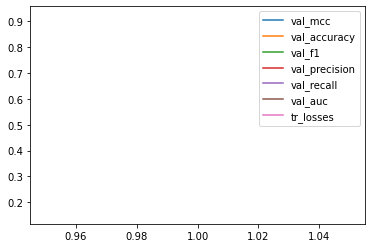

mccs       : [0.7473622259206276]
accuracies : [0.920264284620098]
precisions : [0.8558711098410392]
recalls    : [0.8923829491426781]
f1_scores  : [0.872367097344225]
auc        : [0.9706462821585478]
losses     : [0.15635967627167702]
tr_losses  : [0.15495783416299871]


[{'epoch': 1,
  'training_loss': 0.15495783416299871,
  'eval_loss': 0.15635967627167702,
  'eval_f1': 0.872367097344225,
  'eval_mcc': 0.7473622259206276,
  'eval_precision': 0.8558711098410392,
  'eval_recall': 0.8923829491426781,
  'eval_auc': 0.9706462821585478,
  'eval_accuracy': 0.920264284620098,
  'training_time': '0:32:25',
  'eval_time': '0:01:53'}]

In [24]:
trainer.train ()

In [25]:
training_args = TrainingArguments (

    output_dir       = './results',     # output directory
    num_train_epochs = 1,               # total # of training epochs
    warmup_steps     = 100,             # for lr scheduling
    eval_steps       = 300,             # Number of update steps between two evaluations, if <=0 then eval at end of each epoch
    max_steps        = 0,               # If set to a positive number, the total number of training steps to perform. Overrides num_train_epochs
    learning_rate    = 1e-7,            # Actually = 1e-4 for training from scratch, without using the SAKT_Rishi.pt
    # adam_epsilon=1e-8                 # - default is 1e-8 is “a very small number to prevent any division by zero"
    per_device_train_batch_size = 1024, # batch size per device during training
    per_device_eval_batch_size  = 1024, # batch size for evaluation
)

trainer = MyTrainer (
    
    model         = model,          # the instantiated 🤗 Transformers model to be trained
    args          = training_args,  # training arguments, defined above
    train_dataset = eval_dataset,  # training dataset
    eval_dataset  = None,           # evaluation dataset
)

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB



======== Epoch 1 / 1 ========
Training...
  Average training loss: 0.16
  Training epcoh took: 0:01:46

Training complete!
Total training took 0:01:46 (h:mm:ss)


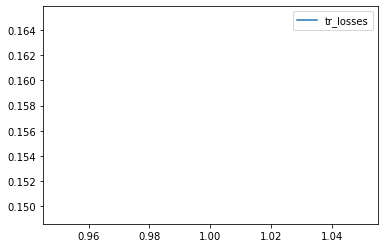

mccs       : -1
accuracies : -1
precisions : -1
recalls    : -1
f1_scores  : -1
auc        : -1
losses     : -1
tr_losses  : [0.15724073871970176]


[{'epoch': 1,
  'training_loss': 0.15724073871970176,
  'training_time': '0:01:46'}]

In [26]:
trainer.train ()

In [27]:
group = train_group.append (eval_group)
print ('len (group) =', len (group))
del train_group, eval_group, train_dataset, eval_dataset, training_args, trainer
gc.collect ()
group

len (group) = 393656


user_id
2058553426    ([7900, 7876, 175, 1278, 2064, 2065, 2063, 336...
1658799651    ([7900, 7876, 175, 1278, 2065, 2064, 2063, 336...
564422495     ([7900, 7876, 175, 1278, 2065, 2063, 2064, 336...
1744078086    ([3560, 8275, 98, 6374, 5070, 5651, 5338, 5673...
1980281378    ([7900, 7876, 175, 1278, 2064, 2063, 2065, 336...
                                    ...                        
1651844166    ([7900, 7876, 175, 1278, 2064, 2063, 2065, 336...
985472128     ([6169, 4325, 7976, 5235, 6678, 5608, 3887, 49...
248149795     ([8277, 6347, 325, 5163, 4764, 4009, 6400, 356...
1706290279    ([3919, 1112, 296, 376, 5976, 5183, 5170, 5849...
1746968974    ([5197, 4290, 4620, 3550, 488, 7951, 3928, 789...
Length: 393656, dtype: object

# get test SAKT Features

In [28]:
class TestDataset (Dataset):
    
    def __init__(self, samples, test_df, skills, max_seq=MAX_SEQ):
        
        super (TestDataset, self).__init__()
        self.samples  = samples
        self.user_ids = [x for x in test_df["user_id"].unique()]
        self.test_df  = test_df
        self.skills   = skills
        self.n_skill  = max (skills) + 1
        self.max_seq  = max_seq
        return
    
    def __len__(self):
        return self.test_df.shape[0]
    
    def __getitem__(self, index):
        
        test_info     = self.test_df.iloc[index]
        user_id       = test_info["user_id"]
        target_id     = test_info["content_id"]
        target_tags   = test_info["tags"]
        target_bundle = test_info["bundle_id"]
        if target_id not in known_qtn_ids:
            target_id = 0
        if target_bundle not in known_bundle_ids:            
            target_bundle = 0
        for i in range (len (target_tags)):
            if target_tags[i] not in known_tags:                
                target_tags[i] = 0
        q  = np.zeros (self.max_seq, dtype=int)
        qa = np.zeros (self.max_seq, dtype=int)
        b  = np.zeros (self.max_seq, dtype=int)
        t  = np.array ([[0]*5]*self.max_seq, dtype=int)  # a question can have upto say 5 tags
        if user_id in self.samples.index:
            
            # q_, qa_, b_, t_ = self.samples[user_id]
            q_, qa_ = self.samples[user_id]
            q_b_t_df = pd.DataFrame.from_dict ({'question_id': q_})
            q_b_t_df = q_b_t_df.merge (questions_df, on='question_id', how='left')
            b_       = q_b_t_df.bundle_id.values
            t_       = np.vstack (q_b_t_df.tags.values)
            del q_b_t_df
            seq_len = len (q_)            
            if seq_len >= self.max_seq:
                
                q  = q_[-self.max_seq:]
                qa = qa_[-self.max_seq:]
                b  = b_[-self.max_seq:]
                t  = t_[-self.max_seq:]
            else:
                
                q[-seq_len:]  = q_
                qa[-seq_len:] = qa_
                b[-seq_len:]  = b_
                t[-seq_len:]  = t_
        
        x = np.zeros (self.max_seq-1, dtype=int)
        x = q[1:].copy ()
        x += (qa[1:] == 1) * self.n_skill
        
        questions = np.append (q[2:], [target_id]) # just [target_id] should do, no need of a sequence of max_seq_len for query Qn_id
        bundle_x  = b[1:].copy ()
        tags_x    = t[1:].copy ()
        b_target  = np.append (b[2:], [target_bundle])
        t_target  = np.vstack ((t[2:], target_tags))
        
        return x, questions, bundle_x, tags_x, b_target, t_target

test_dataset = TestDataset (group, train_df, train_df["content_id"])
item = test_dataset.__getitem__(5)
print (item[0].shape, item[1].shape, item[2].shape, item[3].shape, item[4].shape, item[5].shape)

for item in DataLoader (test_dataset):
    print (item[0].shape, item[1].shape, item[2].shape, item[3].shape, item[4].shape, item[5].shape)
    break

In [29]:
import riiideducation

env       = riiideducation.make_env ()
iter_test = env.iter_test ()

In [30]:
model.eval ()
prev_test_df = None
for (test_df, sample_prediction_df) in tqdm (iter_test):
    
    # test_df = test_df[test_df.content_type_id == False]
    test_df = test_df.merge (questions_df, left_on='content_id', right_on='question_id', how='left').drop (columns=['question_id'])
    if (prev_test_df is not None) & (psutil.virtual_memory ().percent<90):
        
        print (psutil.virtual_memory ().percent)
        prev_test_df['answered_correctly'] = eval (test_df['prior_group_answers_correct'].iloc[0])
        prev_test_df = prev_test_df[prev_test_df.content_type_id == False]
        prev_group = prev_test_df[['user_id', 'content_id', 'answered_correctly', 'bundle_id', 'tags']].groupby ('user_id').apply (lambda r: (
            r['content_id'].values,
            r['answered_correctly'].values,
            r['bundle_id'].values,
            np.vstack (list(r['tags'].values))))
        for prev_user_id in prev_group.index:
            
            prev_group_content = prev_group[prev_user_id][0]
            prev_group_ac      = prev_group[prev_user_id][1]
            prev_group_bund_id = prev_group[prev_user_id][2]
            prev_group_tags    = prev_group[prev_user_id][3]
            if prev_user_id in group.index:
                
                group[prev_user_id] = (np.append(group[prev_user_id][0],  prev_group_content), 
                                       np.append(group[prev_user_id][1],  prev_group_ac))
            else:
                group[prev_user_id] = (prev_group_content, prev_group_ac)
            if len (group[prev_user_id][0]) > MAX_SEQ:
                
                new_group_content   = group[prev_user_id][0][-MAX_SEQ:]
                new_group_ac        = group[prev_user_id][1][-MAX_SEQ:]
                group[prev_user_id] = (new_group_content, new_group_ac)
    prev_test_df    = test_df.copy ()    
    test_df         = test_df[test_df.content_type_id == False]                
    test_dataset    = TestDataset (group, test_df, skills)
    test_dataloader = DataLoader (test_dataset, batch_size=1024, shuffle=False)  # TODO: uncomment this
    outs            = []
    softmax         = nn.Softmax (dim=1)
    for item in tqdm (test_dataloader):
        
        # item = (x, questions, bundle_x, tags_x, b_target, t_target)
        x         = item[0].to (device).long ()
        target_id = item[1].to (device).long ()
        bundle_x  = item[2].to (device).long ()
        tags_x    = item[3].to (device).long ()
        b_target  = item[4].to (device).long ()
        t_target  = item[5].to (device).long ()
        
        with torch.no_grad ():
            pred_logits = model (x, target_id, bundle_x, tags_x, b_target, t_target)  # returns a named tuple
        pred_logits = pred_logits.logits.cpu ()
        pred_pr     = softmax (pred_logits).numpy ()
        pred_pr     = pred_pr[:, 1]   # return the prob of binary class=1
        
        # pred = (output >= 0.5).long()
        # loss = criterion(output, label)
        # val_loss.append(loss.item())
        # num_corrects += (pred == label).sum().item()
        # num_total += len(label)
        # labels.extend(label.squeeze(-1).data.cpu().numpy())
        outs.extend (pred_pr)
        
    test_df['answered_correctly'] =  outs
    env.predict (test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])

0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  4.10it/s]
1it [00:00,  3.50it/s]
  0%|          | 0/1 [00:00<?, ?it/s]

42.0



100%|██████████| 1/1 [00:00<00:00,  3.50it/s]
2it [00:00,  3.17it/s]
  0%|          | 0/1 [00:00<?, ?it/s]

42.2



100%|██████████| 1/1 [00:00<00:00,  3.84it/s]
3it [00:00,  3.20it/s]
  0%|          | 0/1 [00:00<?, ?it/s]

42.1



100%|██████████| 1/1 [00:00<00:00,  2.58it/s]
4it [00:01,  2.35it/s]


In [31]:
print ("Done !")

Done !
